## Honey Bee Classification Model

## Contents:


1.   Introduction
2.   Dataset
3.   Data Augumentation
4.   Transfer Learning
5.   Training, Validating and Testing Model.
6.   Evaluation



 # 1. Introduction:
 
Most the food that we eat today relies on pollination by bees. Honey bees have varieties of subspecies. The differences across these species can lead to differences in  temperament, disease resistance, productivity, color. So it is neccessry to identify different classes of subspecies.In this notebook, The honey bee classfication model is implemented using pytorch framework.  

# 2. Dataset
To solve this task, I am using - The BeeImage Dataset: Annotated Honey Bee Images is the 
 <a href="https://www.kaggle.com/jenny18/honey-bee-annotated-images" target="_blank">dataset</a> 
which contains 5,100 odd bee images with columns location, date, time, subspecies, health condition, caste, and pollen.To begin with dataset, I divided the 5k images into 3 subspecies category namely Italian honey bee, Carniolan honey bee, Russian honey bee using the dataset csv file. So basically this model classifys into the above mentioned 3 subspecies. The best evaluation for classification model is obtained when the dataset is balanced. So I have made sure a balanced dataset while dividing into sub categories.



In [ ]:
# importing csv module 
import csv 
import os
import glob
import numpy as np
from PIL import Image
import shutil
# csv file name 
filename = "bee_data.csv"
  
# initializing the titles and rows list 
fields = [] 
rows = [] 
i=j=k=l=m=0

def copy_into_train_folders(class_name,img_name):
 
    path =  'bee_imgs/'+img_name
    outpath = 'bees_dataset/train/'+class_name
    shutil.copy(path, outpath)

def copy_into_test_folders(class_name,img_name):
 
    path =  'bee_imgs/'+img_name
    outpath = 'bees_dataset/test/'+class_name
    shutil.copy(path, outpath)

def copy_into_val_folders(class_name,img_name):
 
    path =  'bee_imgs/'+img_name
    outpath = 'bees_dataset/validation/'+class_name
    shutil.copy(path, outpath)        
    
    
# reading csv file 
with open(filename, 'r') as csvfile: 
    # creating a csv reader object 
    csvreader = csv.reader(csvfile,delimiter = ',') 
      
    
    fields = next(csvreader) 
    for col in csvreader:
        if   col[5] == 'Italian honey bee':
            if i < 40:
              copy_into_train_folders('Italian_honey_bee',col[0])  
              i = i+1
            elif 40<i<50 : 
              copy_into_val_folders('Italian_honey_bee',col[0]) 
              i=i+1
            else: 
              copy_into_test_folders('Italian_honey_bee',col[0]) 
              i=i+1    
        elif col[5] == 'Carniolan honey bee':
              if k < 40:
                copy_into_train_folders('Carniolan_honey_bee',col[0])  
                k = k+1
              elif 40<k<50 : 
                copy_into_val_folders('Carniolan_honey_bee',col[0]) 
                k=k+1
              else: 
                copy_into_test_folders('Carniolan_honey_bee',col[0]) 
                k=k+1 
          
        elif col[5] == 'Russian honey bee':
            if l < 40:
                copy_into_train_folders('Russian_honey_bee',col[0])  
                l = l+1
            elif 40<l<50 : 
                  copy_into_val_folders('Russian_honey_bee',col[0]) 
                  l=l+1
            else: 
                  copy_into_test_folders('Russian_honey_bee',col[0]) 
                  l=l+1  
        else:
              continue         



Below are the neccessary imports and dependencies.

1.   !pip install torch
2.   !pip install torchvision
3.   !pip install numpy
4.   !pip install pandas
5.   !pip install matplotlib
6.   !pip install seaborn





In [2]:
# Imports here
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
import json

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models

In [3]:
data_dir = '/content/drive/MyDrive/bees_dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/validation'
test_dir = data_dir + '/test'

# 3. Data Augumentation

The strategy which enables to increase the diversity of data available for training models, without actually collecting new data. Here I augumented data by resizing, cropping, flipping, roatating and normalizing as required by the trained model input. The data is than loaded into batch for training and testing.



In [4]:
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)


train_loader = torch.utils.data.DataLoader(training_dataset, batch_size = 64,shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset,batch_size=32)
test_loader = torch.utils.data.DataLoader(testing_dataset,batch_size=32)

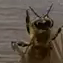

In [7]:
#Displaying some sample images of the dataset
from PIL import Image
img1 = '/content/drive/MyDrive/bees_dataset/train/Italian_honey_bee/017_000.png'
img2 = '/content/drive/MyDrive/bees_dataset/train/Russian_honey_bee/002_034.png'
img3 = '/content/drive/MyDrive/bees_dataset/train/Carniolan_honey_bee/046_197.png'
Image.open(img1)

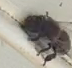

In [5]:
Image.open(img2)

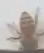

In [8]:
Image.open(img3)

# 4. Transfer Learning

It is a method of using pre-trained models to solve deep learning problems. A pre-trained model is a model is built by someone else and trained on huge data with powerful GPU. In TL approach we can perform fixed feature extraction or
Freeze some layers and train and new layers (Fine tuning). 

In Fixed feature extraction, the data we are trying to train the model on, should be very similar to the data that pre-trained model was originally trained on. And the fine tuning can be adopted when data similarity is very low.


In [5]:
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
for parameter in model.parameters():
    parameter.requires_grad = False
from collections import OrderedDict

classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 5000)),
                                        ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(p=0.5)),
                                        ('fc2', nn.Linear(5000, 3)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

# 5. Training, Validating and Testing Model

There are three seperate functions for training, validating and testing. Training the model for 20 epochs, using Adam aptimizer and negative log likelihood loss funtion with learning rate of 0.001. The validation and training accuracy are printed. And the complete test accuracy is printed.

In [7]:
def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validateloader):

        images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

In [8]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [9]:
def train_classifier():

        epochs = 20
        steps = 0
        print_every = 2
        
        model.to('cuda')

        for e in range(epochs):
        
            model.train()
    
            running_loss = 0
            train_accuracy = 0
    
            for images, labels in iter(train_loader):
        
                steps += 1
        
                images, labels = images.to('cuda'), labels.to('cuda')
        
                optimizer.zero_grad()
        
                output = model.forward(images)
                probabilities = torch.exp(output)
                equality = (labels.data == probabilities.max(dim=1)[1])
                train_accuracy += equality.type(torch.FloatTensor).mean()

                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
        
                running_loss += loss.item()
              
                if steps % print_every == 0:
                    
                
                    model.eval()
              
                    with torch.no_grad():
                        validation_loss, accuracy = validation(model, validate_loader, criterion)
            
                    print("Epoch: {}/{}.. ".format(e+1, epochs),
                          "Val Loss: {:.3f}.. ".format(validation_loss/len(validate_loader)),
                          "Val Acc: {:.3f}".format(accuracy/len(validate_loader)),
                          "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                          "Training Acc: {:.3f}.. ".format(train_accuracy/print_every),)
            
                    running_loss = 0
                    model.train()
                    
data = train_classifier()

Epoch: 1/20..  Val Loss: 14.361..  Val Acc: 0.407 Training Loss: 2.020..  Training Acc: 0.360.. 
Epoch: 2/20..  Val Loss: 2.828..  Val Acc: 0.667 Training Loss: 11.380..  Training Acc: 0.618.. 
Epoch: 3/20..  Val Loss: 2.792..  Val Acc: 0.630 Training Loss: 3.840..  Training Acc: 0.690.. 
Epoch: 4/20..  Val Loss: 5.278..  Val Acc: 0.630 Training Loss: 1.824..  Training Acc: 0.704.. 
Epoch: 5/20..  Val Loss: 2.855..  Val Acc: 0.778 Training Loss: 1.755..  Training Acc: 0.796.. 
Epoch: 6/20..  Val Loss: 1.031..  Val Acc: 0.926 Training Loss: 0.307..  Training Acc: 0.911.. 
Epoch: 7/20..  Val Loss: 0.588..  Val Acc: 0.926 Training Loss: 0.470..  Training Acc: 0.910.. 
Epoch: 8/20..  Val Loss: 0.683..  Val Acc: 0.926 Training Loss: 0.805..  Training Acc: 0.884.. 
Epoch: 9/20..  Val Loss: 1.146..  Val Acc: 0.852 Training Loss: 0.430..  Training Acc: 0.935.. 
Epoch: 10/20..  Val Loss: 1.960..  Val Acc: 0.815 Training Loss: 0.248..  Training Acc: 0.934.. 
Epoch: 11/20..  Val Loss: 2.649..  Va

Now testing the model on the test dataset

In [16]:
def test_accuracy(model, test_loader):

    # Do validation on the test set
    model.eval()
    model.to('cuda')

    with torch.no_grad():
    
        accuracy = 0
        
        i=0
        for images, labels in iter(test_loader):
            
    
            images, labels = images.to('cuda'), labels.to('cuda')
    
            output = model.forward(images)

            probabilities = torch.exp(output)
        
            equality = (labels.data == probabilities.max(dim=1)[1])
            #print(i)
            #i= i+1
            accuracy += equality.type(torch.FloatTensor).mean()
        
        print("Test Accuracy: {}".format(accuracy/len(test_loader)))    
        
        
test_accuracy(model, test_loader)

Test Accuracy: 0.8484209179878235


Saving the model weights, which can later be taken to test on any new images.

In [17]:
def save_checkpoint(model):

    model.class_to_idx = training_dataset.class_to_idx

    checkpoint = {'arch': "vgg16",
                  'class_to_idx': model.class_to_idx,
                  'model_state_dict': model.state_dict()
                 }

    torch.save(checkpoint, 'checkpoint.pth')
    
save_checkpoint(model)   

# Evaluation:

It is always neccessary to evaluate the model, after it is trained and tested. Evaluation helps in application of any model in real time. To evaluate this model I am using confusion matrix.

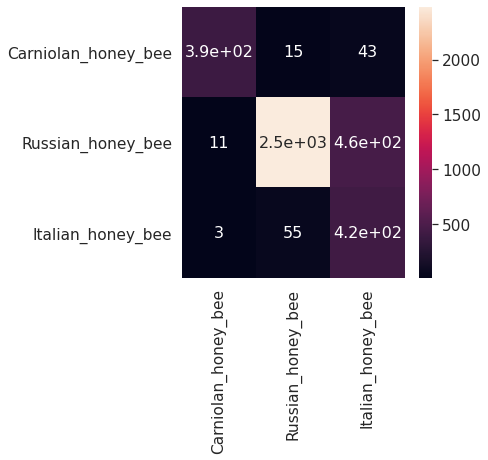

In [36]:
nb_classes = 3
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to('cuda')
        classes = classes.to('cuda')
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(5,5))

class_names = ['Carniolan_honey_bee','Russian_honey_bee','Italian_honey_bee']
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)

sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()




In [37]:
# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[87.16814159 83.98107469 87.86610879]


Above are accuracy obtained on the each class.